In [1]:
import sys
sys.path.append('../')
from src.kiss_data import KissRawData

In [2]:
kd = KissRawData('/data/KISS/Raw/nika2c-data3/KISS/X20190301_1045_S0137_Moon_SCIENCEMAP')
kd

KissRawData('/data/KISS/Raw/nika2c-data3/KISS/X20190301_1045_S0137_Moon_SCIENCEMAP')

In [3]:
print(len(kd))

2241536


In [4]:
print(kd.names)

TName(ComputedDataSc=['sample', 'indice', 'sample_dur', 't_mac', 'A_time', 'A_hours', 'A_time_ntp', 'A_time_pps', 'A_pulse_pps', 'A_freq', 'A_masq', 'A_n_inj', 'B_time', 'A_n_mes', 'B_hours', 'B_time_ntp', 'B_time_pps', 'B_pulse_pps', 'B_freq', 'B_masq', 'C_time', 'B_n_inj', 'B_n_mes', 'C_hours', 'C_time_ntp', 'C_time_pps', 'C_pulse_pps', 'C_motor1_step', 'C_motor2_step', 'C_motor1_pos', 'C_motor2_pos', 'C_laser1_pos', 'C_laser2_pos', 'F_azimuth', 'F_elevation'], ComputedDataSd=['I', 'Q', 'RF_deco', 'RF_didq', 'F_tone', 'amplitude', 'logampl', 'ph_IQ', 'ph_rel', 'k_flag', 'sampleU'], ComputedDataUc=['E_X', 'E_status', 'F_state', 'F_nbsubsc', 'F_subsc', 'G_j1', 'G_j2', 'G_j3', 'G_Jpi'], ComputedDataUd=['u_phi', 'u_width', 'u_itfamp'], RawDataDetector=['KA000', 'KA001', 'KA002', 'KA003', 'KA004', 'KA005', 'KA006', 'KA007', 'KA008', 'KA009', 'KA010', 'KA011', 'KA012', 'KA013', 'KA014', 'KA015', 'KA016', 'KA017', 'KA018', 'KA019', 'KA020', 'KA021', 'KA022', 'KA023', 'KA024', 'KA025', 'KA02

In [5]:
print(kd.header)

TconfigHeader(size_MotorModulTable=8192, nb_brut_ud=3, nb_boites_mesure=8, nb_detecteurs=800, nb_pt_bloc=1024, nb_sample_fichier=0, nb_det_mini=0, nb_brut_uc=9, version_header=4, nb_param_c=72, nb_param_d=7, lg_header_util=75400, nb_brut_c=32, nb_brut_d=2, nb_brut_periode=0, nb_data_c=0, nb_data_d=0, nb_champ_reglage=17)


In [6]:
print(kd.kidpar)

index typedet frequency level width flag namedet masqdet acqbox array
----- ------- --------- ----- ----- ---- ------- ------- ------ -----
    0       1 367100790     3     0    0   KA000       0      1     1
    1       1 367253380     3     0    0   KA001       0      1     1
    2       1 367394520     3     0    0   KA002       0      1     1
    3       1 367741660     3     0    0   KA003       0      1     1
    4       1 368775440     3     0    0   KA004       0      1     1
    5       1 369374350     3     0    0   KA005       0      1     1
    6       1 370797230     3     0    0   KA006       0      1     1
    7       1 370797230     3     0    0   KA007       0      1     1
    8       1 371071890     3     0    0   KA008       0      1     1
    9       1 371209220     3     0    0   KA009       0      1     1
  ...     ...       ...   ...   ...  ...     ...     ...    ...   ...
   --       0         0     0     0    0   NB157       0      2     1
   --       0       

In [7]:
kd.read_data()

In [8]:
kd.calib_raw()

NameError: name 'fid' is not defined

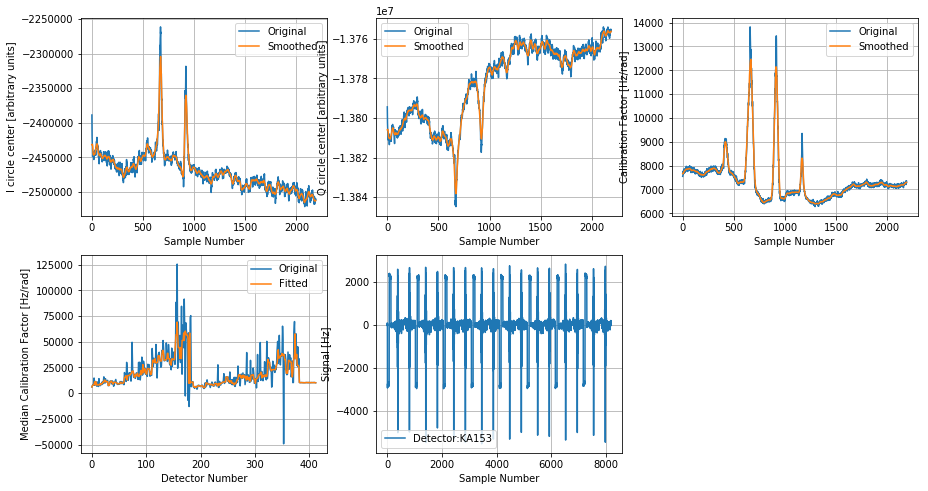

In [9]:
fig = kd.calib_plot()
fid.savefig('calib.pdf')